In [13]:
import sympy
sp = sympy
import numpy as np
from scipy.integrate import odeint,RK45,solve_ivp
import matplotlib.pyplot as plt

In [14]:
def Riccati_solution(a,b,c,tau,init_val):
    if b**2 - 4.0*a*c < 0.0:
        print('riccati negative')
    g = sp.sqrt(b**2 - 4.0*a*c)
    ex = sp.exp(g*tau) - 1
    num = 2*g*init_val + ((b+g)*init_val+2*c)*ex
    denom = 2*g - (2*a*init_val+b-g)*ex
    return num/denom

def Riccati_solution_vec(a,b,c,tau,init_val):
    n = len(a)
    res = np.zeros(n)
    for i in range(n):
        res[i] = Riccati_solution(a[i],b[i],c[i],tau,init_val[i])
    return res
    
def int_Riccati_solution(a,b,c,tau,ricc_init_val):
    if b**2 - 4.0*a*c < 0.0:
        print('int riccati negative')
    g = sp.sqrt(b**2 - 4.0*a*c)
    ex = sp.exp(g*tau) - 1
    term1 = (-b+g)*tau/(2.0*a) 
    term2 = sp.log(2*g/sp.Abs(2*g+(g-b-2*a*ricc_init_val)*ex))/a
    return term1 + term2

def int_Riccati_solution_vec(a,b,c,tau,ricc_init_val):
    n = len(a)
    res = np.zeros(n)
    for i in range(n):
#        print(int_Riccati_solution(a[i],b[i],c[i],tau,ricc_init_val[i]))
        res[i] = int_Riccati_solution(a[i],b[i],c[i],tau,ricc_init_val[i])
    return res

def get_E_vAvB(t,alp,beta,sigma,v0):
    res = np.exp(-beta*t)*(v0 - alp/beta) + alp/beta
    return res.prod()

def get_A(tau,correlation,u,Bi_param,Ci_param):
    mu0 = Bi_param['mu0']
    l0 = Bi_param['l0']
    ka = Bi_param['ka']
    alp = Ci_param['alp']
    beta = Ci_param['beta'] 
    sigma = Ci_param['sigma'] 
    v0 = Ci_param['v0'] 
    sAsB = correlation[0,2] # sA(0) vA(1) sB(2) vB(3)
    vAsB = correlation[1,2]
    sAvB = correlation[0,3]
    A = 0.0 # initial value for A
    E_vAvB = get_E_vAvB(30.0,alp,beta,sigma,v0) # presume
    # int(const)
    A += ((u*mu0).sum() + l0*u.sum()+E_vAvB*u.prod()*sAsB)*tau
    # int(Bi)
    A += (ka*th*int_Riccati_solution_vec(Bi_param['a'],Bi_param['b'],Bi_param['c'],tau,Bi_param['init_val'])).sum()
    # int(Ci)
    A += ((alp + np.array([u[1]*vAsB,u[0]*sAvB])*sigma*E_vAvB)*int_Riccati_solution_vec(Ci_param['a'],Ci_param['b'],Ci_param['c'],tau,Ci_param['init_val'])).sum()
#     A += ((alp + np.array([u[1]*vAsB,u[0]*sAvB])*E_vAvB)*int_Riccati_solution_vec(Ci_param['a'],Ci_param['b'],Ci_param['c'],tau,Ci_param['init_val'])).sum()
    return A

def get_chf(tau,Bi_param,Ci_param,u,correlation):
    A = get_A(tau,correlation,u,Bi_param,Ci_param)
    Bi = Riccati_solution_vec(Bi_param['a'],Bi_param['b'],Bi_param['c'],tau,Bi_param['init_val'])
    Ci = Riccati_solution_vec(Ci_param['a'],Ci_param['b'],Ci_param['c'],tau,Ci_param['init_val'])
    return np.exp(A + np.dot(Bi,Bi_param['x0']) + np.dot(Ci,Ci_param['v0']))

def get_CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return sample

In [15]:
args = (0.005,-0.25,2) # a,b,c need to put realistic numbers
t = np.linspace(0, 30, 100)
y0 = [1.0]

a, b, c, tau, init_val = sp.symbols("a b c tau init_val")

Vega Kappa Sigma Lambda0 Lambda1
0.0071789087893710636	0.91955317271506032	0.079225954492688294	0.0060143056850302115	0.33406218084747519
0.026791457724679751	0.65519716144767481	0.061915823381776328	-0.024040627706502959	0.567193787366429
0.0041764252498052122	0.00016824092656831811	0.16070586134556636	0.002936459547620166	-0.43539851995741613
Pivot mat Pivot yield
0.25	0.015470045999999897
8	0.018333333333333333
9	0.018666666666666665

US LC


In [25]:
# How to compute a Chf
# US parameters
# for treasury param
l0 = -0.127061
# presume constant shift
ve = np.array([0.2715618,0.0195524,0.0009720])
ka = np.array([5.6772530,0.2520333,0.147])
th = ve/ka
si = np.array([0.0181427,0.0422960,0.034]) # adjusted si[2]
x0 = np.array([0.05095958,0.06725220,0.00961570])
# Equity parameters (US LC, OS)
s0 = np.array([0.0,0.0]) # initial value
mu0 = np.array([0.000815,0.000822]) # official value
mu0 = np.array([0.07,0.110]) # my value
mu1 = np.array([-0.5,-0.5]) # I think just -0.5 is too strict? High volatility -> Always stock crush
# mu1 = np.array([-0.001,-0.002]) + np.array([-0.5,-0.5]) # I think just -0.5 is too strict?
v0 = np.array([0.019528084,0.080837794])
alp = np.array([0.022,0.108045])
beta = np.array([0.98803,1.284485])
sigma = np.array([0.142303,0.121922]) # volatility of variance
vbar = alp/beta

# sA vA sB vB
# correlation parameters
sAvA = -0.5
sAsB = 0.15 # It is important 
sAvB = -0.5
vAsB = -0.5
vAvB = 0.5
sBvB = -0.5

#presume no cross correlation
# test case
# no correlation fine
# sAvA, sBvB are fine. (cross correlation is zero)
# Fully correlated -> chf 333,MC 556
# I think the scale of the cross correlation b.t.w. A & B is important
# If correlation is fully independent, it is fine.
# Allowing sAvA and sBvB is fine
# sAvA = -0.0
# sAsB = 0.0 # This impacts
# sAvB = 0.0
# vAsB = 0.0
# vAvB = 0.0 # It is ignored in Andrea's formula
# sBvB = -0.0

correlation = np.matrix([[1,sAvA,sAsB,sAvB],
                         [sAvA,1,vAsB,vAvB],
                         [sAsB,vAsB,1,sBvB],
                         [sAvB,vAvB,sBvB,1]])
if np.sum(np.linalg.eigvals(correlation) < 0):
    print('Correlation matrix is not positive definite!')
L = np.linalg.cholesky(correlation) # Cholesky decomposition of the correlation for simulation

Characteristic function (phi)
phi = E_{t}[exp(uAsA+uBsB+wi*xi+pAvA+pBvB)] = exp(A + Bi*xi + Cj*vj +uj*sj)

In [26]:
# test parameters

# chf parameters
# u is not fine 6.756838706555411 11.115305305630752
# wi is fine 1.1408511635460272
# psi is fine 1.11277473457259
u = np.array([1.0, 1.0]) # uA uB
# u = np.array([0.1, 0.1]) # uA uB
wi = [1,1,1] # weight for treasury state variables
psi = [1.0, 1.0] # weight for variance process
# u = np.array([0.0, 0.0]) # uA uB
# wi = [0,0,0] # weight for treasury state variables
# psi = [0.0, 0.0] # weight for variance process


tau = t[-1]
# compute Bi (treasury parameter)
Bi_param = {'a':0.5*si**2,'b':-ka,'c':sum(u)*np.ones(len(ka)),'init_val':wi}
Bi_param['mu0'] = mu0
Bi_param['l0'] = l0
Bi_param['x0'] = x0
Bi_param['ka'] = ka
Bi = Riccati_solution_vec(Bi_param['a'],Bi_param['b'],Bi_param['c'],tau,Bi_param['init_val'])
int_Bi = int_Riccati_solution_vec(Bi_param['a'],Bi_param['b'],Bi_param['c'],tau,Bi_param['init_val'])

# compute Ci for variance process
# heston model's parameter
Ci_param = {'a':0.5*sigma**2, 'b':(u*np.array([sAvA,sBvB])*sigma-beta), 'c':0.5*u**2+u*mu1,'init_val':psi}
Ci_param['alp'] = alp
Ci_param['beta'] = beta
Ci_param['sigma'] = sigma
Ci_param['v0'] = v0

Ci = Riccati_solution_vec(Ci_param['a'],Ci_param['b'],Ci_param['c'],tau,Ci_param['init_val'])
int_Ci = int_Riccati_solution_vec(Ci_param['a'],Ci_param['b'],Ci_param['c'],tau,Ci_param['init_val'])

# Ai_param['a'] 
A = get_A(tau,correlation,u,Bi_param,Ci_param)
Bi = Riccati_solution_vec(Bi_param['a'],Bi_param['b'],Bi_param['c'],tau,Bi_param['init_val'])
Ci = Riccati_solution_vec(Ci_param['a'],Ci_param['b'],Ci_param['c'],tau,Ci_param['init_val'])
print('A ',A)
print('B ',Bi)
print('C ',Ci)
# Compute ChF
np.exp(A + np.dot(u,s0) + np.dot(Bi,x0) + np.dot(Ci,v0))

A  5.323564771519748
B  [ 0.35228665  8.16686377 14.16919632]
C  [1.60055688e-14 2.97038380e-18]


414.4711822554628

In [27]:
get_chf(tau,Bi_param,Ci_param,u,correlation)

414.4711822554628

# Monte Carlo Simulation

In [28]:
# tau = t[-1]
np.random.seed(1)
num_steps = int(tau*500)
num_paths = 5000
res = np.zeros((num_steps, num_paths))
dt = tau/num_steps
t_sim = np.linspace(0.0,tau,num_steps+1)
# Initialize states

x = np.zeros([num_steps+1, len(x0), num_paths]) # middle: num state var
r = np.zeros([num_steps+1, num_paths])
s = np.zeros([num_steps+1, len(s0), num_paths])
v = np.zeros([num_steps+1, len(v0), num_paths])

# Initialization
r[0,:] = l0
for j in range(len(x0)):
    x[0,j,:] = x0[j]
    r[0,:] += x0[j]
for j in range(len(s0)):
    s[0,j,:] = s0[j]
    v[0,j,:] = v0[j]
    
for i in range(num_steps):
    # noncentral chisquare processes
    # Treasury
    r[i+1,:] = l0
    for j in range(len(x0)): # x1,x2,x3
        x[i+1,j,:] = get_CIR_Sample(num_paths,ka[j],si[j],th[j],0,dt,x[i,j,:])
        r[i+1,:] += x[i+1,j,:]

    # Volatility
    dW_indep = np.random.normal(0.0,1.0,(4,num_paths))
    dW = L*dW_indep*np.sqrt(dt) # each row (sA vA sB vB)
    for j in range(len(v0)): # j in (A,B)
        drift_term = (alp[j] - beta[j]*v[i,j,:])*dt
        if j == 0: # A
            dWv = dW[1,:]
        elif j == 1: # B
            dWv = dW[3,:]
        vol_term = sigma[j]*np.multiply(np.sqrt(v[i,j,:]),dWv)
        vol_term += 0.25*sigma[j]**2.0 * (np.power(dWv,2) - dt) # Milstein term
        v[i+1,j,:] = np.maximum(0.0,v[i,j,:] + drift_term + vol_term) # truncation
#         v[i+1,j,:] = np.abs(v[i,j,:] + drift_term*dt + vol_term ) # reflection
    
    # Stock price
    for j in range(len(s0)): # j in (A,B)
        drift_term = (np.add(r[i], mu0[j]) + mu1[j]*v[i,j,:])*dt
        if j == 0: # A
            dWs = dW[0,:]
        elif j == 1: # B
            dWs = dW[2,:]
        vol_term = np.multiply(np.sqrt(v[i,j,:]), dWs)
        s[i+1,j,:] = s[i,j,:] + drift_term + vol_term # reflection
    

# Characteristic Function from MC

In [29]:
chf = np.mean(np.exp(np.dot(u,s[-1,:,:]) + np.dot(psi,v[-1,:,:]) + np.dot(wi,x[-1,:,:])))
print(chf)

490.2964993035471


In [30]:
chf_MC = np.zeros(len(t_sim))
chf_analytic = np.zeros(len(t_sim))
for i,t_step in enumerate(t_sim):
    chf_MC[i] = np.mean(np.exp(np.dot(u,s[i,:,:]) + np.dot(psi,v[i,:,:]) + np.dot(wi,x[i,:,:])))
    chf_analytic[i] = get_chf(t_step,Bi_param,Ci_param,u,correlation)

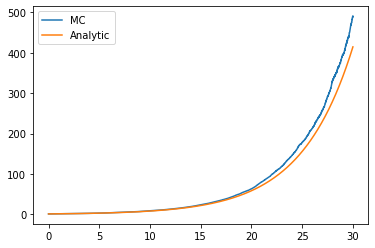

In [31]:
plt.plot(t_sim,chf_MC,label='MC')
plt.plot(t_sim,chf_analytic,label='Analytic')
plt.legend()

In [23]:
from scipy.stats import skew,kurtosis
# simulation result check
print('IR mean sim: ',r[-1,:].mean(),' steady-state ',th.sum()+l0)
print('mean of s ', s[-1,:,:].mean(axis=1))
print('var of s ', s[-1,:,:].var(axis=1))
print('skew of s ', skew(s[-1,:,:],axis=1))
print('kurtosis of s ', kurtosis(s[-1,:,:],axis=1))
print('x ss ',th)
print('Ex sim ',x[-1,0,:].mean(), x[-1,1,:].mean(), x[-1,2,:].mean())
print('v ss ',alp/beta)
print('Ev sim ',v[-1,0,:].mean(), v[-1,1,:].mean())
v_exact0 = get_CIR_Sample(num_paths,beta[0],sigma[0],(alp/beta)[0],0.0,tau,v0[0])
v_exact1 = get_CIR_Sample(num_paths,beta[1],sigma[1],(alp/beta)[1],0.0,tau,v0[1])
print('v exact ',v_exact0.mean(),' ',v_exact1.mean())

IR mean sim:  0.004850011083623458  steady-state  0.0049631918489159155
mean of s  [1.88872758 2.19315678]
var of s  [0.75523773 2.65522375]
skew of s  [-0.20393954 -0.04091502]
kurtosis of s  [ 0.10382688 -0.01203984]
x ss  [0.04783331 0.07757864 0.00661224]
Ex sim  0.04783957702173772 0.07741622705263689 0.006655207009248864
v ss  [0.02226653 0.08411542]
Ev sim  0.021904981597170945 0.08395754383410815
v exact  0.02235121968975165   0.08393968096916389


In [24]:
Bi_cpy = Bi_param.copy()
Ci_cpy = Ci_param.copy()
# mean of sA, sB
du = 0.01
Bi_cpy['init_val'] = np.zeros(len(x0)) # zero wi
Ci_cpy['init_val'] = np.zeros(len(v0)) # zero psi
EsA = (get_chf(t_sim[-1],Bi_cpy,Ci_cpy,np.array([du,0]),correlation) - get_chf(t_sim[-1],Bi_cpy,Ci_cpy,np.array([0,0]),correlation))/du
EsB = (get_chf(t_sim[-1],Bi_cpy,Ci_cpy,np.array([0,du]),correlation) - get_chf(t_sim[-1],Bi_cpy,Ci_cpy,np.array([0,0]),correlation))/du
print('EsA ',EsA)
print('MC sA ',s[-1,0,:].mean())
print('EsB ',EsB)
print('MC sB ',s[-1,1,:].mean())

# mean of vA, vB
Bi_cpy = Bi_param.copy()
Bi_cpy['init_val'] = np.zeros(len(x0)) # zero wi
Ci_cpy = Ci_param.copy()
Ci_cpy_2 = Ci_param.copy()
Ci_cpy['init_val'] = np.zeros(len(v0)) # zero psi
Ci_cpy_2['init_val'] = np.array([du,0.0]) # zero psi
u_cpy = 0.0*u.copy()
EvA = (get_chf(t_sim[-1],Bi_cpy,Ci_cpy_2,u_cpy,correlation) - get_chf(t_sim[-1],Bi_cpy,Ci_cpy,u_cpy,correlation))/du
print('EvA ',EvA)
print('MC vA ',v[-1,0,:].mean())
Ci_cpy_2['init_val'] = np.array([0.0,du]) # zero psi
EvB = (get_chf(t_sim[-1],Bi_cpy,Ci_cpy_2,u_cpy,correlation) - get_chf(t_sim[-1],Bi_cpy,Ci_cpy,u_cpy,correlation))/du
print('EvB ',EvB)
print('MC vB ',v[-1,1,:].mean())


EsA  -5090.527749213243
MC sA  1.888727580267359
EsB  -1531.1891816340449
MC sB  2.1931567765029567
EvA  62.30633759264492
MC vA  0.021904981597170945
EvB  240.9566173060739
MC vB  0.08395754383410815
